In [1]:
%%capture
%cd ..

In [2]:
# Import data

import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from utils.constants import white_list

In [3]:
cleaned =  pd.read_csv('dataset/cleaned/charge-CS2_36.csv')

[1.159089409818447, 1.1411188847637739, 1.1397386057520809, 1.139087996128884, 1.138794063587793, 1.1363302080524709, 1.1345099326840296, 1.1277515132999705, 1.1209349571925227, 1.1177018705426773, 1.114996692123733, 1.1129062279196358, 1.1172719806210694, 1.1181362546879932, 1.117943982775616, 1.117722713533924, 1.1172183458001008, 1.1169414724660847, 1.1164623953587594, 1.1158812670963414, 1.1150997036438675, 1.114459829972759, 1.1138860983437944, 1.1133757000426172, 1.112958512859361, 1.1121939818982867, 1.111500748891963, 1.109014872570885, 1.1005176327224078, 1.097212066779914, 1.0951094234176288, 1.0932131831024172, 1.093315804000433, 1.0996076239579011, 1.0985488070797516, 1.0907335616737512, 1.087597066860262, 1.0872341445805205, 1.0859354507739383, 1.088042766567014, 1.0932634331763822, 1.0920683420890143, 1.0841084553021503, 1.0829217862169784, 1.082428020886411, 1.0813126430294062, 1.0820910830385486, 1.088082950968321, 1.0873935860710944, 1.0808028345184297, 1.0796802945799

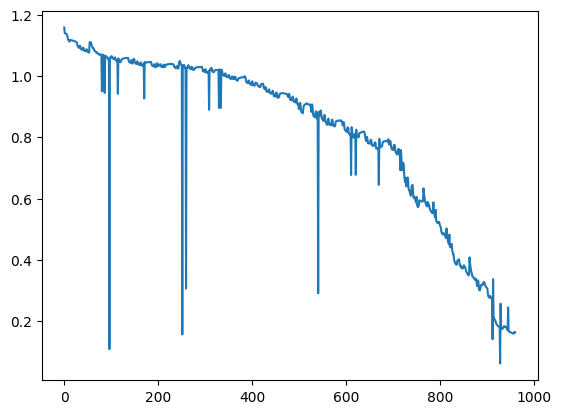

In [5]:
first_step_index_2 = cleaned[cleaned['Step_Index'] == 2].groupby('Cycle_Index').head(1)
last_step_index_4 = cleaned[cleaned['Step_Index'] == 4].groupby('Cycle_Index').tail(1)
cycle_indexes2 = first_step_index_2['Cycle_Index'].index # ha indice riga e numero del ciclo
cycle_indexes4 = last_step_index_4['Cycle_Index'].index 

first = []
for i in cycle_indexes2:
    first.append(cleaned.iloc[i,6])

last = []
for i in cycle_indexes4:
    last.append(cleaned.iloc[i,6])
    
result = [b - a for a, b in zip(first, last)]
print(result)

dim = len(result)
print(dim)

plt.plot(result)

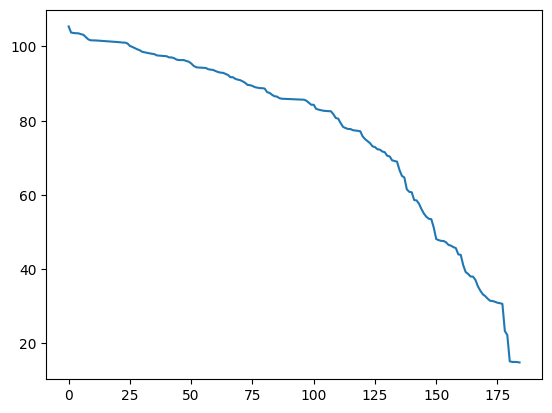

In [6]:
for i in range(len(result) - 1, 0, -1):
    
    if result[i - 1] <= result[i]:
        del result[i - 1]


valori = []
for j in range(len(result)):
    val = (result[j]/(1.1))
    val = val*100
    valori.append(val)



plt.plot(valori)